In [1]:
import torch
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T
from random import randint
from IPython.display import clear_output

import numpy as np
import pylab as pl

from src import *

In [2]:
N_CHANNELS = 15        # Number of CA state channels
TARGET_PADDING = 8     # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 4
POOL_SIZE = 512
CELL_FIRE_RATE = 0.5

torch.backends.cudnn.benchmark = True # Speeds up things

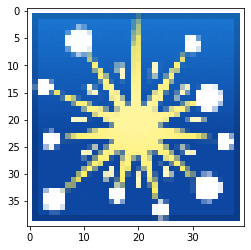

In [3]:
# Imports the target emoji
target = read_image("images/firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [4]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target = target.to(device)

model = MultipleCA(N_CHANNELS, n_CAs=2, device=device)

In [5]:
# checkpoint = {
#     "state_dict": model.CAs[1].state_dict(),
#     "pool": pool.images,
#     "loss": model.losses
# }

# torch.save(checkpoint, "330_epoch.pt")

In [6]:
def state_to_image(x, mask_channels):
    alpha = x[:, mask_channels].sum(dim=1).unsqueeze(1)
    return torch.cat((x[:, :3], alpha), dim=1)

In [7]:
folder = "Pretrained_models/Virus/Virus lorenzo/"
model.CAs[0].load(folder + "firework_growing_64_96.pt")
model.CAs[1].load(folder + "firework_virus_ckp_2.pt")

Successfully loaded model!
Successfully loaded model!


In [8]:
for param in model.CAs[0].parameters():
    param.requires_grad = False

generator = VirusGenerator(N_CHANNELS, IMAGE_SIZE, 2, model, virus_rate=0.8, iter_func=ExponentialSampler(min=48, max=64))
pool = SamplePool(POOL_SIZE, generator)

In [8]:
wandb.init(project="quick_virus", entity="neural_ca")

wandb: Currently logged in as: lettera (use `wandb login --relogin` to force relogin)


In [46]:
class WeightFunction:
    def __init__(self, l, steps_per_epoch, initial_step=0):
        self.l = l
        self.steps_per_epoch = steps_per_epoch
        self.initial_step = initial_step

    def get_current_step(self, epoch, n_step):
        return epoch * self.steps_per_epoch + n_step

    def __call__(self, n_step, epoch):
        step = self.get_current_step(epoch, n_step) - self.initial_step
        
        if step < 0:
            return 0

        return min(self.l * step**2, 1)

In [47]:
class WeightedLoss(nn.Module):
    """Weights the loss with a function of the number of steps and the epoch"""
    def __init__(self, loss_function: nn.Module, weight_function) -> None:
        super().__init__()
        self.loss_function = loss_function
        self.weight_function = weight_function
    
    def __call__(self, x, n_step, epoch):
        return self.loss_function(x) * self.weight_function(n_step, epoch)

In [49]:
class CombinedLoss(nn.Module):
    def __init__(self, loss_functions:List[nn.Module], weights:List[float], log_step:int=96):
        super().__init__()
        self.loss_functions = loss_functions
        self.weights = weights
        self.log_step = log_step

    def __call__(self, x, n_step, epoch):
        device = x.device
        losses = torch.zeros(x.size()[0], device=device)
        for i, loss_function in enumerate(self.loss_functions):
            losses += self.weights[i] * loss_function(x, n_step, epoch)
        
        return losses

In [50]:
L_target = NCALoss(pad(target, TARGET_PADDING), alpha_channels=[15, 16])
L_original_cells = CellRatioLoss(alpha_channels=[15, 16])

weight_function = WeightFunction(1e-4, steps_per_epoch=96, initial_step=72)
L_target = WeightedLoss(L_target, weight_function)
L_original_cells = WeightedLoss(L_original_cells, weight_function)

loss_function = CombinedLoss([L_target, L_original_cells], [1, 1], log_step=95)

In [18]:
wandb.init(mode="disabled")

In [51]:
params = model.CAs[1].parameters()

optimizer = torch.optim.Adam(params, lr=2e-3)
criterion = loss_function
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,80], gamma=0.3)

model.train_CA(optimizer, criterion, pool, n_epochs=1, skip_update=2, batch_size=3,
               scheduler=scheduler, kind="persistent", skip_damage=1, n_max_losses=1,
               evolution_iters=96)

/home/lettera/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([4, 48, 48])) that is different to the input size (torch.Size([3, 4, 48, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 1
avg loss: 0.003997876935789142


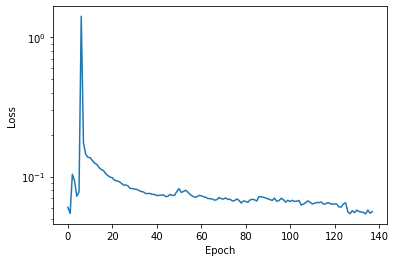

In [7]:
pl.plot(model.losses)
pl.xlabel("Epoch")
pl.ylabel("Loss")
pl.yscale("log")
pl.show()
# pl.savefig(fname="perturbation_regeneration_l=1_side=20_losses.png", dpi=200)

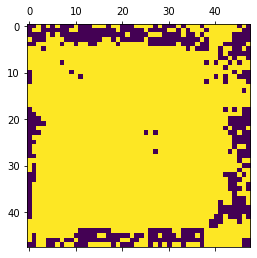

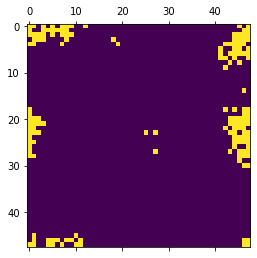

In [61]:
pl.matshow(inputs[0, -1].cpu()>0.1)
pl.matshow(inputs[0, -2].cpu()>0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


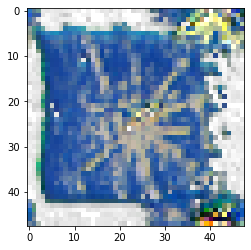

In [64]:
def state_to_image(x, mask_channels):
    alpha = x[:, mask_channels].sum(dim=1).unsqueeze(1)
    return torch.cat((x[:, :3], alpha), dim=1)

inputs = pool.sample(1)[0].detach().cuda()

inputs = model.evolve(inputs, 80)


imshow(state_to_image(inputs, [-1, -2])[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


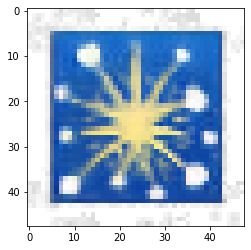

In [81]:
def state_to_image(x, mask_channels):
    alpha = x[:, mask_channels].sum(dim=1).unsqueeze(1)
    return torch.cat((x[:, :3], alpha), dim=1)

inputs = pool.sample(1)[0].detach().cuda()

imshow(state_to_image(inputs, [-1, -2])[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


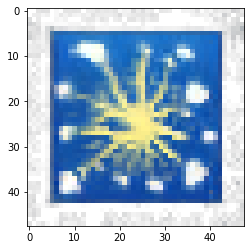

In [84]:
# recursive forward-pass
inputs = model.evolve(inputs, 30)

imshow(state_to_image(inputs, [-1, -2])[0])

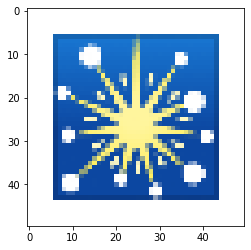

In [21]:
# Plots the true emoji
imshow(TraintoFloat(pad(target, 10, -1)))